In [44]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [45]:
from typing import DefaultDict, List, Hashable, Dict, Any

from src.utils.utils import get_generator, get_project_root, make_path_if_not_exists

from src.pipeline.config import DataLoaderConfig, TaskLoaderConfig
from src.pipeline.taskloader import TaskLoader
from src.pipeline.dataloader import DataLoader

from src.orchestrator.trainer import Trainer
from src.utils.result_fetcher import ResultFetcher

from src.settings.tier import Tier
from src.settings.strategy import Strategy

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import itertools


In [46]:
MODE = 'talk'
FIGSIZE = (0, 0)
DPI = 0

# Paper dimensions

# Presentation dimensions
LABEL_SIZE_TALK = 16
DPI_TALK = 96
FIGSIZE_TALK = (13.33, 7.5)
FONTSIZE_TALK = 18

# Result analysis
In this section we aim to analyse the training performance of all the models, we make a comparison over all tiers, over all strategies and we compare architectures to each other

In [47]:
def get_metabolite_info():
    metabolite_data = pd.read_csv('./data/training/metabolites.txt', delimiter='\t')
    raw_metabolites = pd.read_csv('./data/training/metabolites_dataset.data_prep.tsv', delimiter='\t')

    return raw_metabolites.merge(
        metabolite_data, 
        left_on='official_name', right_on='met_name'
    )[['metabolite_id', 'official_name', 'kegg_id', 'pathway', 'method', 'Order']].drop_duplicates().set_index('metabolite_id')

def gather_results(paths: List[str]):
    metabolites_names = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('Strategy.METABOLITE_CENTRIC_') for path in paths]
    df = pd.concat([
        pd.read_csv(path).assign(metabolite_id=metabolite_name) 
        for path, metabolite_name in zip(paths, metabolites_names)
    ])
    return df

def combine_metabolite_info(df):
    metabolite_info = get_metabolite_info()
    df = df.merge(metabolite_info, left_on='metabolite_id', right_index=True)
    return df

def set_context(mode):
    if mode == 'talk':
        sns.set_context(
            "talk",
            rc={
                "font_size": FONTSIZE_TALK,
                "axes.labelsize": LABEL_SIZE_TALK,
            }
        )
        fig = plt.figure(figsize=FIGSIZE_TALK, dpi=DPI_TALK)

def save_fig(path: str, name: str):
    make_path_if_not_exists(path)
    plt.savefig(f"{path}/{name}.png", bbox_inches='tight')
    plt.savefig(f"{path}/{name}.svg", bbox_inches='tight')

metabolite_info = get_metabolite_info()

result_fetcher = ResultFetcher(
    root_dir="/home/tvangraft/tudelft/thesis/metaengineering/data/results",
    metabolite_info=metabolite_info
)

tiers = [Tier.TIER0, Tier.TIER1]
strategies = [Strategy.ALL, Strategy.METABOLITE_CENTRIC, Strategy.ONE_VS_ALL]

def get_best_model_performance(tier, strategy):
    root_dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results"
    test_pred_df = pd.read_json(
        f'{root_dir}/{tier}/best_model_prediction_performance_{strategy}.json'
    )
    test_pred_df = test_pred_df.T.reset_index().drop("index", axis=1).set_axis(['y_true', 'y_pred', 'architecture', 'metabolite_id', 'correlation'], axis=1) \
        .merge(metabolite_info, left_on='metabolite_id', right_index=True) \
        .assign(strategy=strategy).assign(experiment_id=tier)
    return test_pred_df

test_pred_df = pd.concat([get_best_model_performance(tier, strategy) for tier, strategy in itertools.product(tiers, strategies)])
test_pred_df['error'] = test_pred_df.apply(lambda row: mean_absolute_error(row['y_true'], row['y_pred']), axis=1)


In [113]:
def transform_str_to_list(list_string: str):
    if type(list_string) != str:
        return np.NAN

    return [float(x) for x in list_string.replace("'", "").replace("[", "").replace("]", "").split(", ")]

In [115]:
tier_2_results = pd.read_csv(f"./data/validation/gnn_model_protein_only_evaluation.csv")
tier_2_results = tier_2_results.assign(experiment_id=Tier.TIER2)
tier_2_results['architecture'] = tier_2_results['mode'].apply(lambda x: f"{x.replace('metabolite_gnn_sweep_full_', '')}")
tier_2_results['strategy'] = tier_2_results['strategy'].replace({f'{Strategy.ONE_VS_ALL}': 'one_vs_all', f'{Strategy.ALL}': 'all', f'{Strategy.METABOLITE_CENTRIC}': 'metabolite'})
tier_2_results = tier_2_results.rename({'metrics.R2 score': 'correlation', 'metrics.Mean absolute error': 'error'}, axis=1)
tier_2_results = tier_2_results.assign(experiment_id=Tier.TIER2).astype('object')
tier_2_results['architecture'] = tier_2_results['architecture'].replace('all', 'full')

tier_2_results_opt = tier_2_results.loc[tier_2_results.groupby(['experiment_id', 'strategy', 'metabolite_id'])['correlation'].transform(max) == tier_2_results['correlation']]
tier_2_results_opt = tier_2_results_opt.assign(architecture='all')

tier_2_results = tier_2_results[['experiment_id', 'strategy', 'correlation', 'metabolite_id', 'error', 'architecture', 'y_true', 'y_pred']]

tier_2_results['y_true'] = tier_2_results['y_true'].apply(transform_str_to_list)
tier_2_results['y_pred'] = tier_2_results['y_pred'].apply(transform_str_to_list)

tier_2_results = tier_2_results.merge(metabolite_info, left_on='metabolite_id', right_index=True)
tier_2_results

,experiment_id,strategy,correlation,metabolite_id,error,architecture,y_true,y_pred,official_name,kegg_id,pathway,method,Order
0,Tier.TIER2,all,NaN,r5p,0.722256,unfiltered,"[-0.05111140012741089, 1.3853280544281006, 0.1...","[-0.058519646525382996, -0.058519646525382996,...",alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3
1,Tier.TIER2,all,0.240087,r5p,0.71978,unfiltered,"[-0.05111140012741089, 1.3853280544281006, 0.1...","[0.2501451373100281, 0.19814461469650269, 0.24...",alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3
2,Tier.TIER2,all,-0.063211,r5p,0.718658,unfiltered,"[-0.05111140012741089, 1.3853280544281006, 0.1...","[-0.052671339362859726, -0.052671339362859726,...",alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3
3,Tier.TIER2,all,NaN,r5p,0.719443,unfiltered,"[-0.05111140012741089, 1.3853280544281006, 0.1...","[-0.05422510951757431, -0.05422510951757431, -...",alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3
4,Tier.TIER2,all,-0.078347,r5p,0.710062,unfiltered,"[-0.05111140012741089, 1.3853280544281006, 0.1...","[-0.03698136284947395, -0.03817760944366455, -...",alpha-D-Ribose 5-phosphate,C00117,PPP,TCA,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,Tier.TIER2,one_vs_all,NaN,dhap,0.744175,full,"[-1.2058722972869873, 0.34574317932128906, -0....","[0.004077630117535591, 0.004077630117535591, 0...",Dihydroxyacetone phosphate,C00111,Glycolysis,TCA,5
1324,Tier.TIER2,one_vs_all,NaN,dhap,0.764754,full,"[-1.2058722972869873, 0.34574317932128906, -0....","[0.014124872162938118, 0.014124872162938118, 0...",Dihydroxyacetone phosphate,C00111,Glycolysis,TCA,5
1325,Tier.TIER2,one_vs_all,NaN,dhap,0.76449,full,"[-1.2058722972869873, 0.34574317932128906, -0....","[0.00015460350550711155, 0.0008034512866288424...",Dihydroxyacetone phosphate,C00111,Glycolysis,TCA,5
1326,Tier.TIER2,one_vs_all,-0.044061,dhap,0.76815,full,"[-1.2058722972869873, 0.34574317932128906, -0....","[-0.03734079375863075, 0.02935566008090973, 0....",Dihydroxyacetone phosphate,C00111,Glycolysis,TCA,5


In [114]:
tier_3_results = pd.read_csv("./data/validation/gnn_model_metabolite_evaluation.csv")
tier_3_results = tier_3_results.assign(experiment_id=Tier.TIER3)
tier_3_results['architecture'] = tier_3_results['mode'].apply(lambda x: f"{x.replace('metabolite_gnn_sweep_full_', '')}")
tier_3_results['strategy'] = tier_3_results['strategy'].replace({f'{Strategy.ONE_VS_ALL}': 'one_vs_all', f'{Strategy.ALL}': 'all', f'{Strategy.METABOLITE_CENTRIC}': 'metabolite'})
tier_3_results = tier_3_results.rename({'metrics.R2 score': 'correlation', 'metrics.Mean absolute error': 'error'}, axis=1)
tier_3_results = tier_3_results.assign(experiment_id=Tier.TIER3).astype('object')
tier_3_results['architecture'] = tier_3_results['architecture'].replace('all', 'full')


tier_3_results_opt = tier_3_results.loc[tier_3_results.groupby(['experiment_id', 'strategy', 'metabolite_id'])['correlation'].transform(max) == tier_3_results['correlation']]
tier_3_results_opt = tier_3_results_opt.assign(architecture='all')

tier_3_results = tier_3_results[['experiment_id', 'strategy', 'correlation', 'metabolite_id', 'error', 'architecture', 'y_true', 'y_pred']]

tier_3_results['y_true'] = tier_3_results['y_true'].apply(transform_str_to_list)
tier_3_results['y_pred'] = tier_3_results['y_pred'].apply(transform_str_to_list)

tier_3_results = tier_3_results.merge(metabolite_info, left_on='metabolite_id', right_index=True)


tier_3_results

,experiment_id,strategy,correlation,metabolite_id,error,architecture,y_true,y_pred,official_name,kegg_id,pathway,method,Order,mse_error
0,Tier.TIER3,all,NaN,accoa,0.653635,unfiltered,"[0.04585527256131172, 0.4773847162723541, 0.53...","[0.0, 0.0, 0.0, 0.0, 0.0]",Acetyl-CoA,C00024,TCA,TCA,1,0.793299
1,Tier.TIER3,all,NaN,accoa,0.653635,unfiltered,"[0.04585527256131172, 0.4773847162723541, 0.53...","[0.0, 0.0, 0.0, 0.0, 0.0]",Acetyl-CoA,C00024,TCA,TCA,1,0.793299
2,Tier.TIER3,all,NaN,accoa,0.653635,unfiltered,"[0.04585527256131172, 0.4773847162723541, 0.53...","[0.0, 0.0, 0.0, 0.0, 0.0]",Acetyl-CoA,C00024,TCA,TCA,1,0.793299
3,Tier.TIER3,all,-0.110965,accoa,0.631187,unfiltered,"[0.04585527256131172, 0.4773847162723541, 0.53...","[0.037443678826093674, 0.03738389536738396, 0....",Acetyl-CoA,C00024,TCA,TCA,1,0.757631
4,Tier.TIER3,all,0.246237,accoa,0.682643,unfiltered,"[0.04585527256131172, 0.4773847162723541, 0.53...","[-0.1064114198088646, -0.04994292929768562, 0....",Acetyl-CoA,C00024,TCA,TCA,1,0.822403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,Tier.TIER3,metabolite,-0.48332,g6p;g6p-B,1.412313,strict,"[0.00834512710571289, 0.4741881191730499, 0.42...","[-0.01386161521077156, -0.01332460530102253, -...",D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9,0.831929
1212,Tier.TIER3,metabolite,0.269743,g6p;g6p-B,0.755023,strict,"[0.00834512710571289, 0.4741881191730499, 0.42...","[-0.013879486359655857, -0.012832674197852612,...",D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9,0.832207
1213,Tier.TIER3,metabolite,-0.437258,g6p;g6p-B,0.783403,strict,"[0.00834512710571289, 0.4741881191730499, 0.42...","[-0.019078245386481285, -0.034617431461811066,...",D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9,0.837189
1214,Tier.TIER3,metabolite,0.132628,g6p;g6p-B,0.851223,strict,"[0.00834512710571289, 0.4741881191730499, 0.42...","[0.04256374016404152, 0.07341930270195007, 0.0...",D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9,0.806012


In [111]:
full_df['y_true'].value_counts()

[-0.05111140012741089, 1.3853280544281006, 0.14479435980319977, 0.23671190440654755, -1.7310396432876587, 0.2350667119026184, -3.0729055404663086, 0.8745064735412598, 0.2916942834854126, 0.2912707030773163, 0.2350667119026184, 0.07373527437448502, 0.7571691870689392, 0.6193480491638184, -0.32036370038986206, -1.6903809309005737, 0.3119041919708252, 0.7490689158439636, -1.4025983810424805, 0.7475342750549316, 1.1521257162094116, 0.5162558555603027, 0.10462087392807007, 0.6215130686759949, 0.6871421933174133, 0.4502699077129364, 0.41707223653793335, 0.7768676280975342, -0.011682229116559029]                                                                                                                                                                                                                                                                                                                                                                                                                    

In [116]:
full_df = test_pred_df.sort_values(['pathway', 'metabolite_id'])
full_df = pd.concat([
    full_df, 
    tier_2_results.reset_index(drop=True),
    tier_3_results.reset_index(drop=True),
], axis=0).reset_index(drop=True)

full_df = full_df[full_df['y_true'].notna()]
full_df['mse_error'] = full_df.apply(lambda row: mean_squared_error(row['y_true'], row['y_pred']), axis=1)
full_df['mape_error'] = full_df.apply(lambda row: mean_absolute_percentage_error(row['y_true'], row['y_pred']), axis=1)
full_df

,y_true,y_pred,architecture,metabolite_id,correlation,official_name,kegg_id,pathway,method,Order,strategy,experiment_id,error,mse_error,mape_error
0,"[0.8004643864000001, -0.444358136, -1.15033130...","[0.6629026376, -0.2735513475, -0.2478038982, 0...",all,3pg;2pg,0.936379,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.23676,0.137541,0.273360
1,"[0.6668401919, 0.8327306056, 0.7955080275, -1....","[0.7233851045, 0.47184171480000003, 0.86015329...",SVR(),3pg;2pg,0.926913,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.263823,0.154841,0.339717
2,"[-0.8516472012, -0.444358136, 0.45176399380000...","[-0.2651440635, -0.2619513375, 0.3879892343000...",RandomForestRegressor(),3pg;2pg,0.909382,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.175447,0.079873,0.255928
3,"[0.685273315, 0.6100864001, -1.2398104285, 0.7...","[0.38277654780000003, 0.38759057220000004, 0.0...",ElasticNet(),3pg;2pg,0.856592,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.ALL,Tier.TIER0,0.247246,0.153885,0.323645
4,"[0.7137829512, 0.6982001291000001, -0.91118488...","[0.6748898323, 0.6208998961000001, 0.523299206...",all,3pg;2pg,0.196213,3-Phospho-D-glycerate;D-Glycerate 2-phosphate,C00197;C00631,Glycolysis,TCA,11,Strategy.METABOLITE_CENTRIC,Tier.TIER0,0.480005,0.487009,0.871650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631,"[0.00834512710571289, 0.4741881191730499, 0.42...","[-0.01386161521077156, -0.01332460530102253, -...",strict,g6p;g6p-B,-0.48332,D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9,metabolite,Tier.TIER3,1.412313,0.831929,1.052236
2632,"[0.00834512710571289, 0.4741881191730499, 0.42...","[-0.013879486359655857, -0.012832674197852612,...",strict,g6p;g6p-B,0.269743,D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9,metabolite,Tier.TIER3,0.755023,0.832207,1.053277
2633,"[0.00834512710571289, 0.4741881191730499, 0.42...","[-0.019078245386481285, -0.034617431461811066,...",strict,g6p;g6p-B,-0.437258,D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9,metabolite,Tier.TIER3,0.783403,0.837189,1.111615
2634,"[0.00834512710571289, 0.4741881191730499, 0.42...","[0.04256374016404152, 0.07341930270195007, 0.0...",strict,g6p;g6p-B,0.132628,D-Glucose 6-phosphate;beta-D-glucose 6-phosphate,C00092;C01172,Glycolysis,TCA,9,metabolite,Tier.TIER3,0.851223,0.806012,1.104818


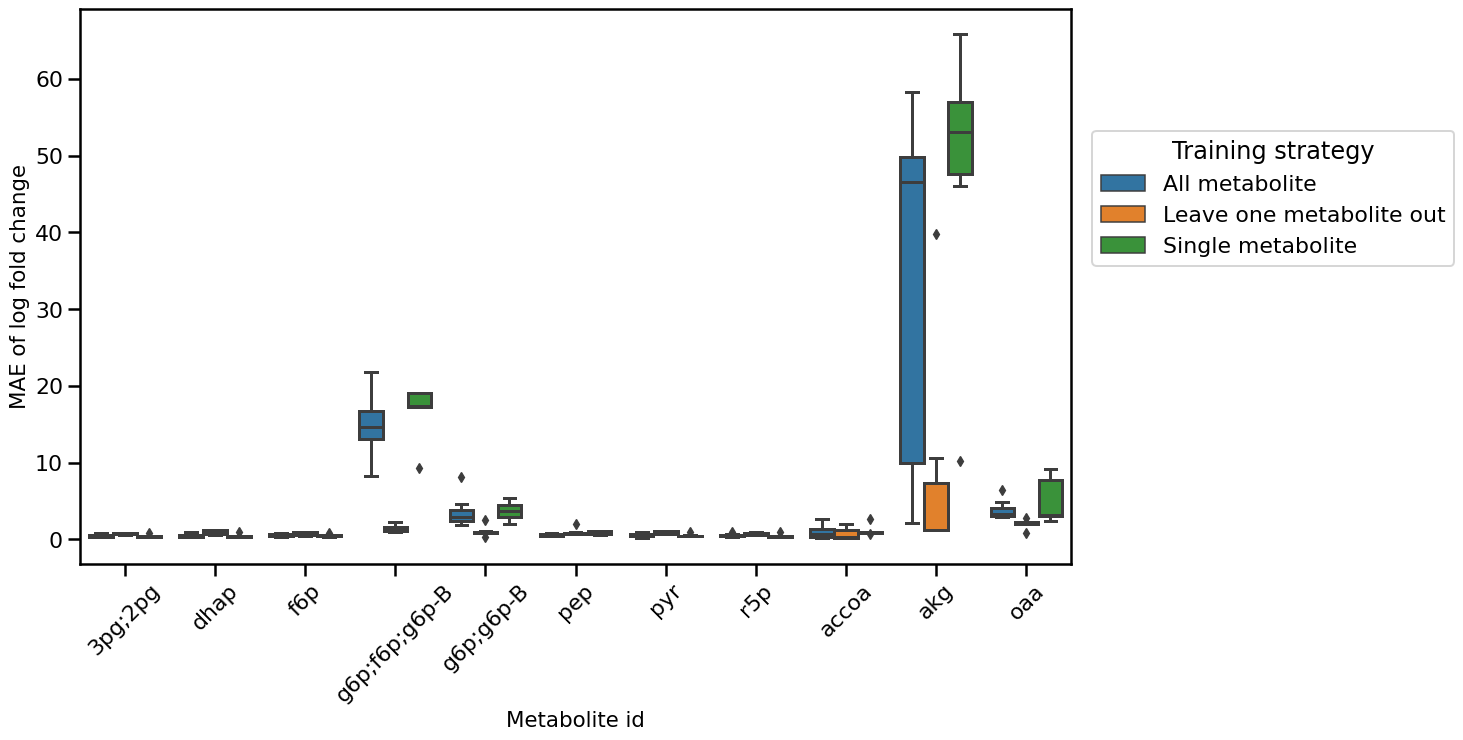

In [117]:
set_context(MODE)
_df = full_df.copy()

_df.strategy = _df.strategy.map({
    Strategy.ALL: 'All metabolite', 
    Strategy.ONE_VS_ALL: 'Single metabolite', 
    Strategy.METABOLITE_CENTRIC: 'Leave one metabolite out'
})


g = sns.boxplot(
    data=_df,
    x='metabolite_id',
    y='mape_error',
    hue='strategy',
)

g.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 0.8), title='Training strategy')

g.set(
    xlabel='Metabolite id',
    ylabel="MAE of log fold change"
)

save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_different_strategies_using_optimal_model")

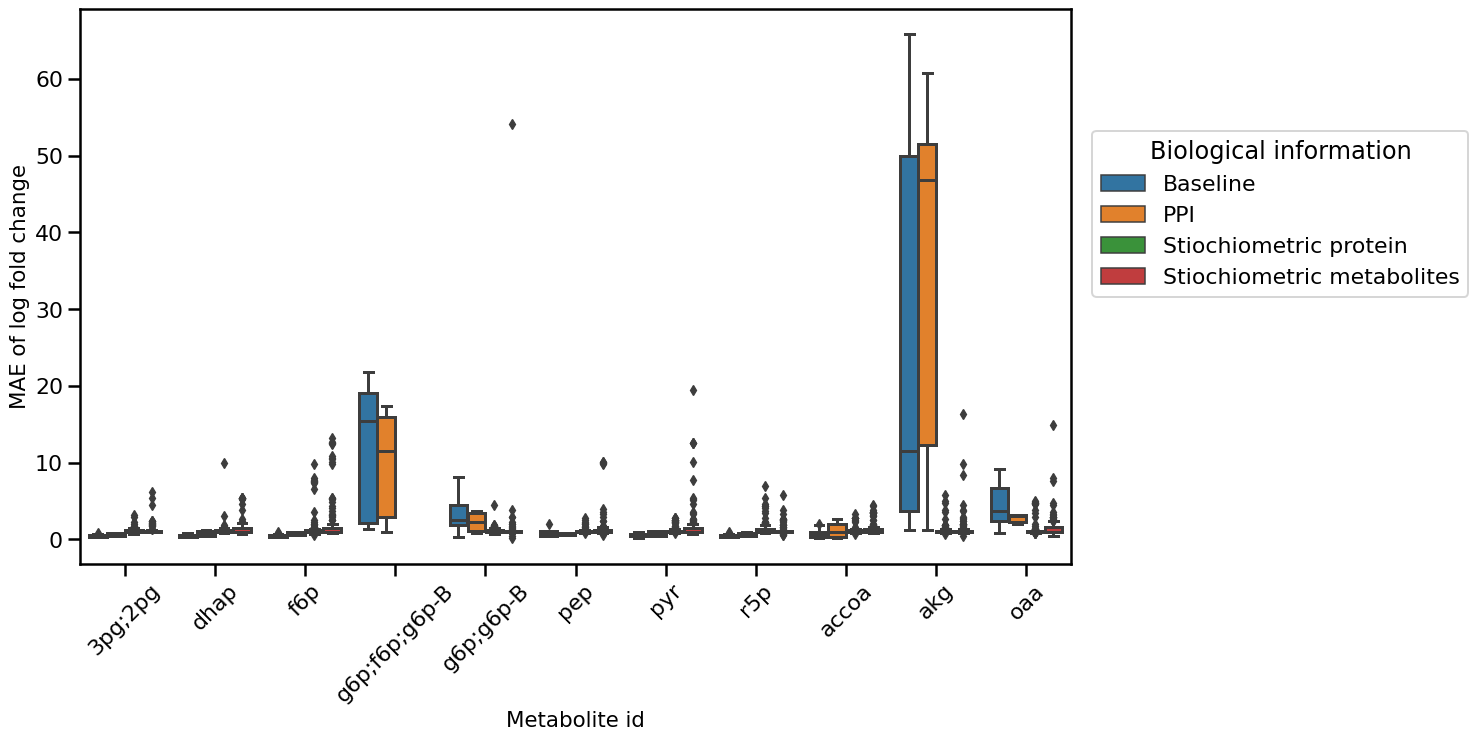

In [118]:
set_context(MODE)
_df = full_df.copy()

_df.experiment_id = _df.experiment_id.map({
    Tier.TIER0: 'Baseline', 
    Tier.TIER1: 'PPI', 
    Tier.TIER2: 'Stiochiometric protein',
    Tier.TIER3: 'Stiochiometric metabolites',
})

g = sns.boxplot(
    data=_df,
    x='metabolite_id',
    y='mape_error',
    hue='experiment_id',
)

g.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 0.8), title='Biological information')

g.set(
    xlabel='Metabolite id',
    ylabel="MAE of log fold change"
)

save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_different_tiers_using_optimal_model")

## Architecture performance

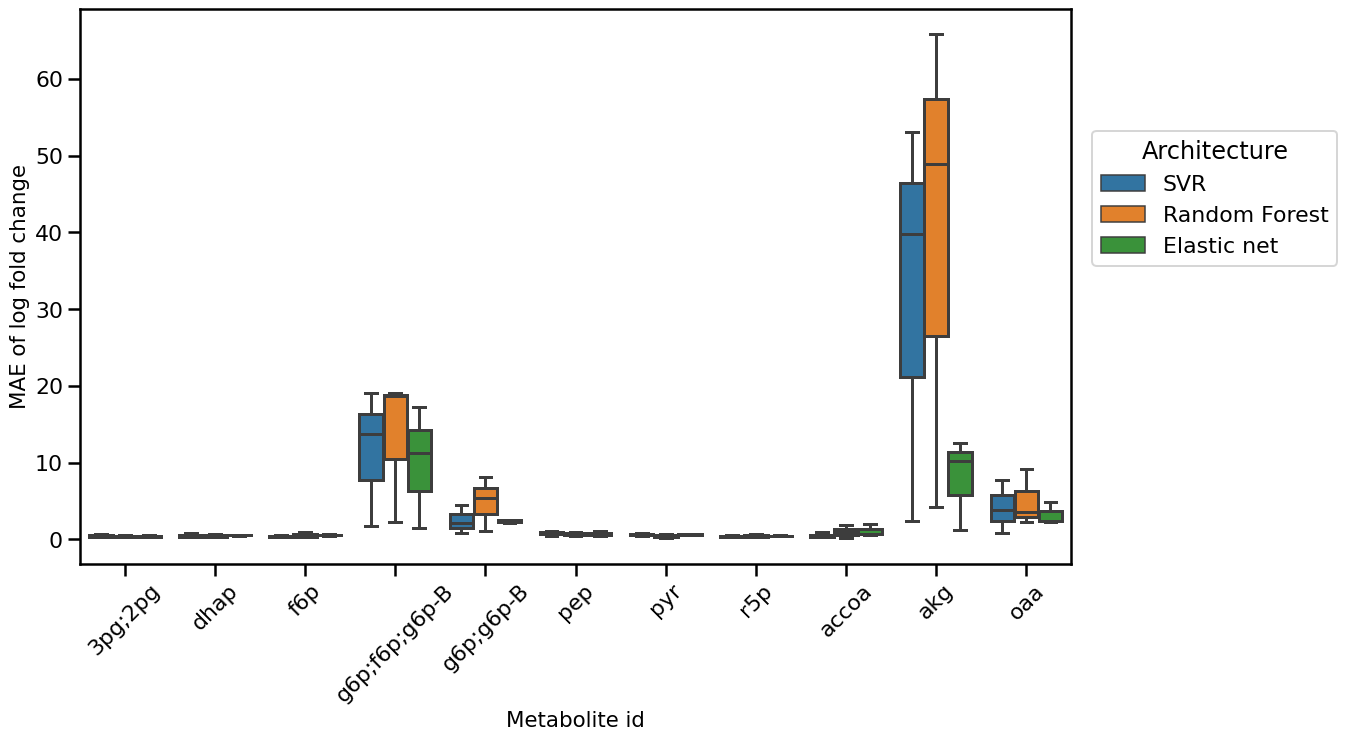

In [120]:
set_context(MODE)
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER0) & (_df['architecture'] != 'all')]

_df.architecture = _df.architecture.map({
    "SVR()": 'SVR', 
    "RandomForestRegressor()": 'Random Forest', 
    "ElasticNet()": 'Elastic net'
})

g = sns.boxplot(
    data=_df,
    x='metabolite_id',
    y='mape_error',
    hue='architecture',
)

g.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 0.8), title='Architecture')

g.set(
    xlabel='Metabolite id',
    ylabel="MAE of log fold change"
)

save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_architectures_tier_0")

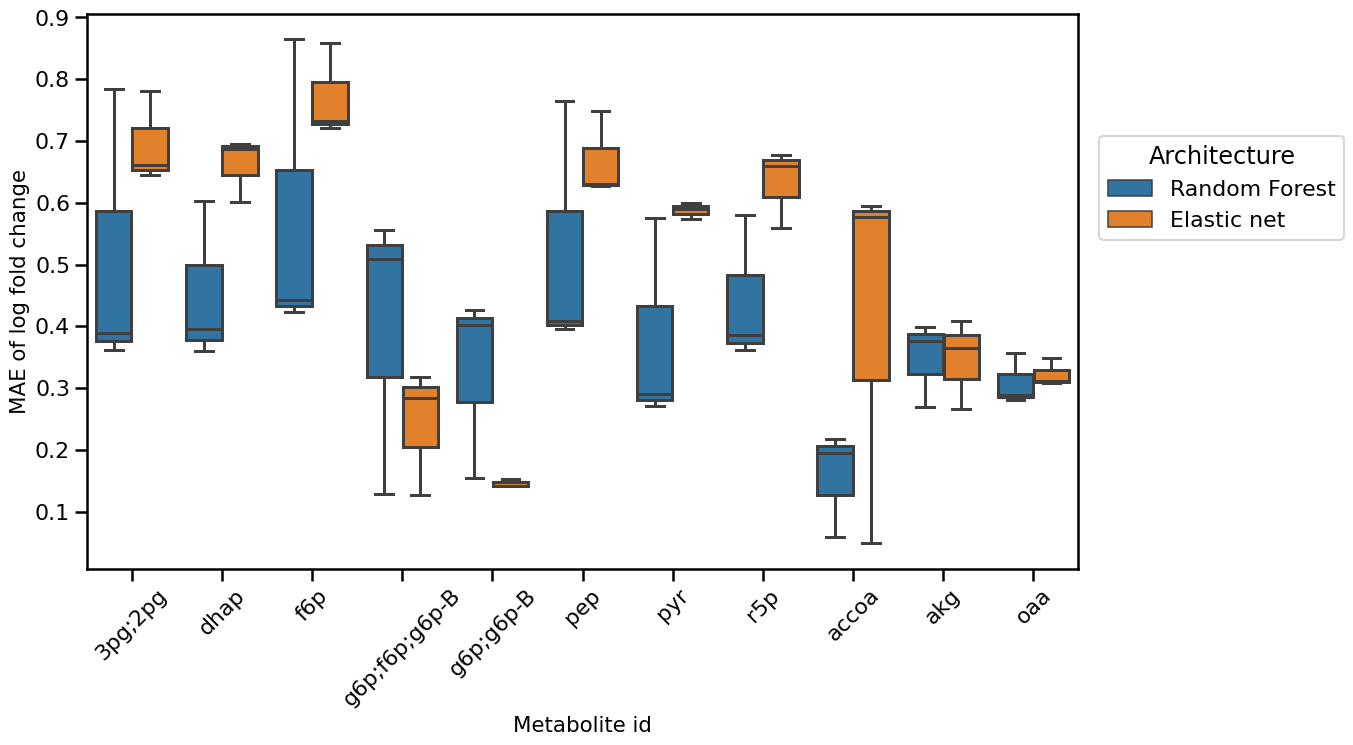

In [55]:
set_context(MODE)
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER1) & (_df['architecture'] != 'all') & (_df['architecture'] != 'SVR()')]

_df.architecture = _df.architecture.map({
    "SVR()": 'SVR', 
    "RandomForestRegressor()": 'Random Forest', 
    "ElasticNet()": 'Elastic net'
})

g = sns.boxplot(
    data=_df,
    x='metabolite_id',
    y='error',
    hue='architecture',
)

g.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 0.8), title='Architecture')

g.set(
    xlabel='Metabolite id',
    ylabel="MAE of log fold change"
)

save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_architectures_tier_1")

In [56]:
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER2) & (_df['architecture'] != 'all')]
_df.groupby('metabolite_id')['error'].mean()

metabolite_id
3pg;2pg      0.753758
accoa        0.746894
akg          0.626515
dhap         0.715978
f6p          0.737416
g6p;g6p-B    0.688265
oaa          0.719481
pep          0.741895
pyr          0.788542
r5p          0.760526
Name: error, dtype: float64

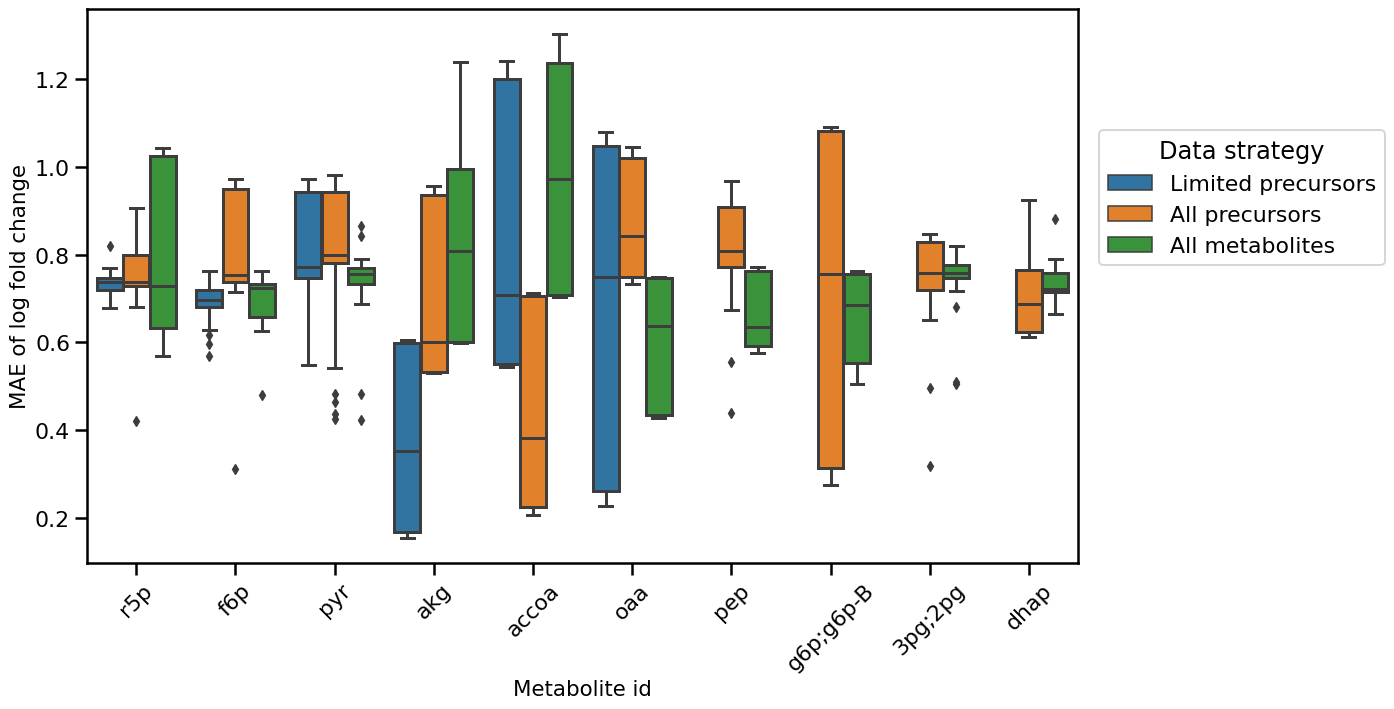

In [57]:
set_context(MODE)
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER2) & (_df['architecture'] != 'all')]

_df.architecture = _df.architecture.map({
    "strict": 'All precursors', 
    "full": 'All metabolites', 
    "unfiltered": 'Limited precursors'
})

g = sns.boxplot(
    data=_df,
    x='metabolite_id',
    y='error',
    hue='architecture',
)

g.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 0.8), title='Data strategy')

g.set(
    xlabel='Metabolite id',
    ylabel="MAE of log fold change"
)

save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_architectures_tier_2")

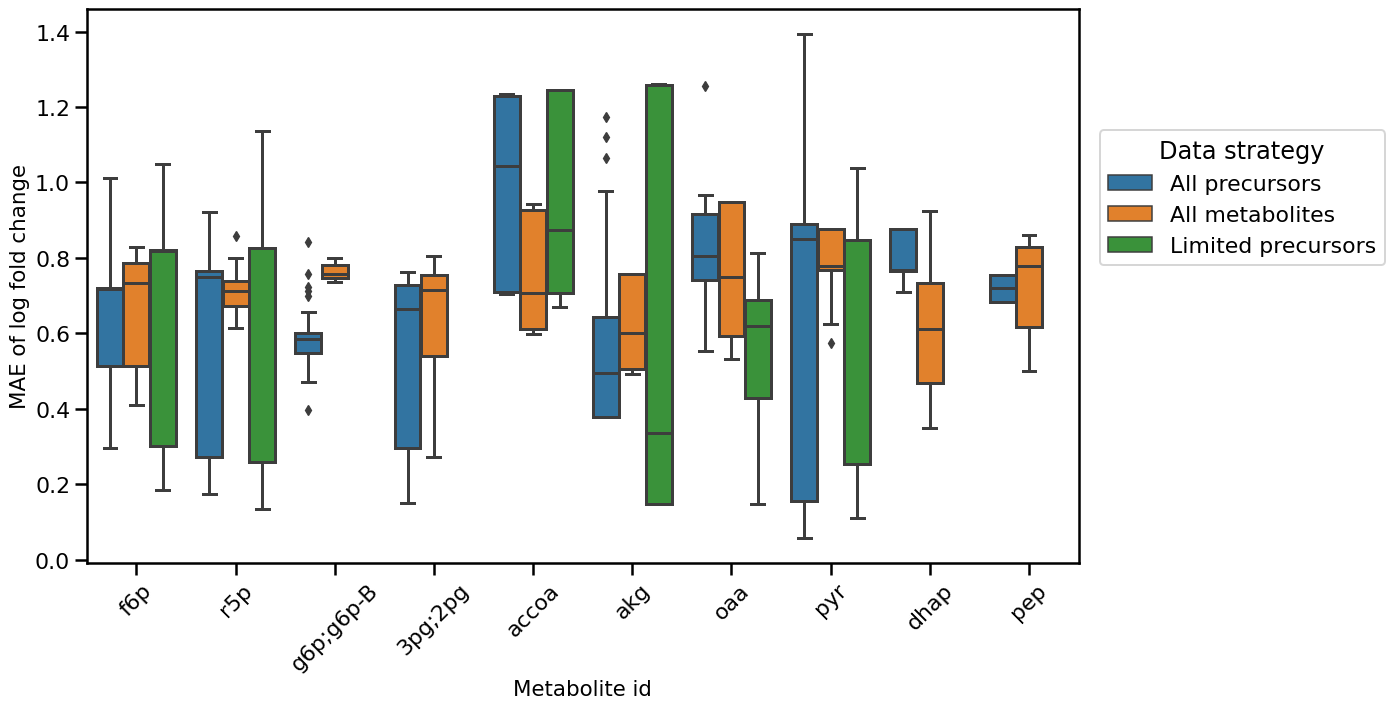

In [58]:
set_context(MODE)
_df = full_df.copy()
_df = _df[(_df['experiment_id'] == Tier.TIER3) & (_df['architecture'] != 'all')]

_df.architecture = _df.architecture.map({
    "strict": 'All precursors', 
    "full": 'All metabolites', 
    "unfiltered": 'Limited precursors'
})

g = sns.boxplot(
    data=_df,
    x='metabolite_id',
    y='error',
    hue='architecture',
)

g.set_xticklabels(g.axes.get_xticklabels(), rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1.01, 0.8), title='Data strategy')

g.set(
    xlabel='Metabolite id',
    ylabel="MAE of log fold change"
)

save_fig(path=f'./images/{MODE}/performance/', name="comparison_between_architectures_tier_3")

# Deep dive into pyruvate

In [59]:
DataLoader.DATA_FOLDER = f'{get_project_root()}/data/training/'
tier = Tier.TIER0

dl_config = DataLoaderConfig(
    additional_filters=['is_precursor'],
    additional_transforms=["log_fold_change_protein"]
)

dl = DataLoader()
dl.prepare_dataloader(dl_config)

tl = TaskLoader()
tl.prepare_taskloader(TaskLoaderConfig())

strategy = Strategy.ALL
gen = get_generator(dl, tl, strategy, tier)
tf = next(gen)

In [60]:
# PDC1, PDC2, PDC5, PDC6
pdc_enzymes = ["YLR044C", "YDR081C", "YLR134W", "YGR087C"]

for pdc_enzyme in pdc_enzymes:
    if pdc_enzyme in tf.x.columns:
        print(pdc_enzyme)

YLR044C
YGR087C


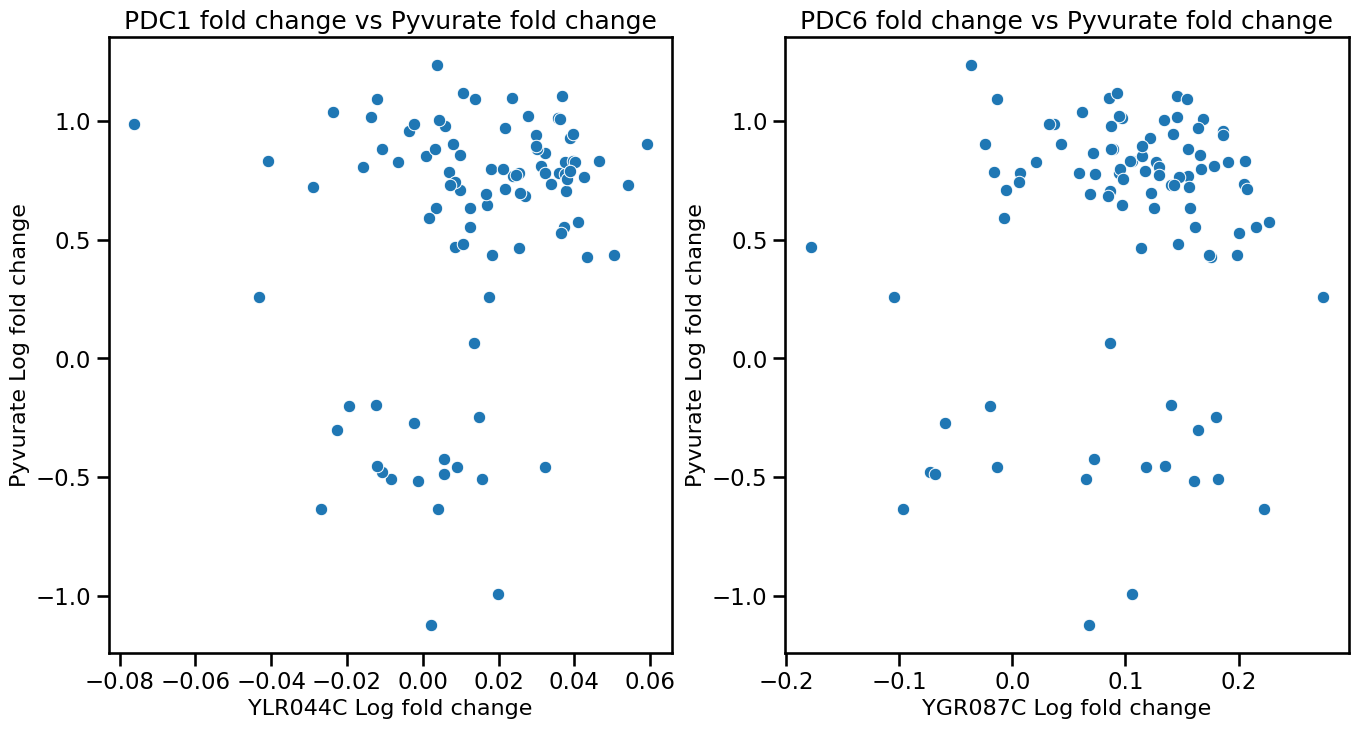

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
_df = pd.concat([
    tf.x.droplevel(1).drop_duplicates(), 
    tf.y.unstack(1)
], axis=1)

sns.scatterplot(
    data=_df,
    x="YLR044C",
    y="pyr",
    ax=ax1
).set(
    title='PDC1 fold change vs Pyvurate fold change',
    xlabel='YLR044C Log fold change',
    ylabel='Pyvurate Log fold change'
)
sns.scatterplot(
    data=_df,
    x="YGR087C",
    y="pyr",
    ax=ax2,
).set(
    title="PDC6 fold change vs Pyvurate fold change",
    xlabel='YGR087C Log fold change',
    ylabel='Pyvurate Log fold change'
)
plt.show()

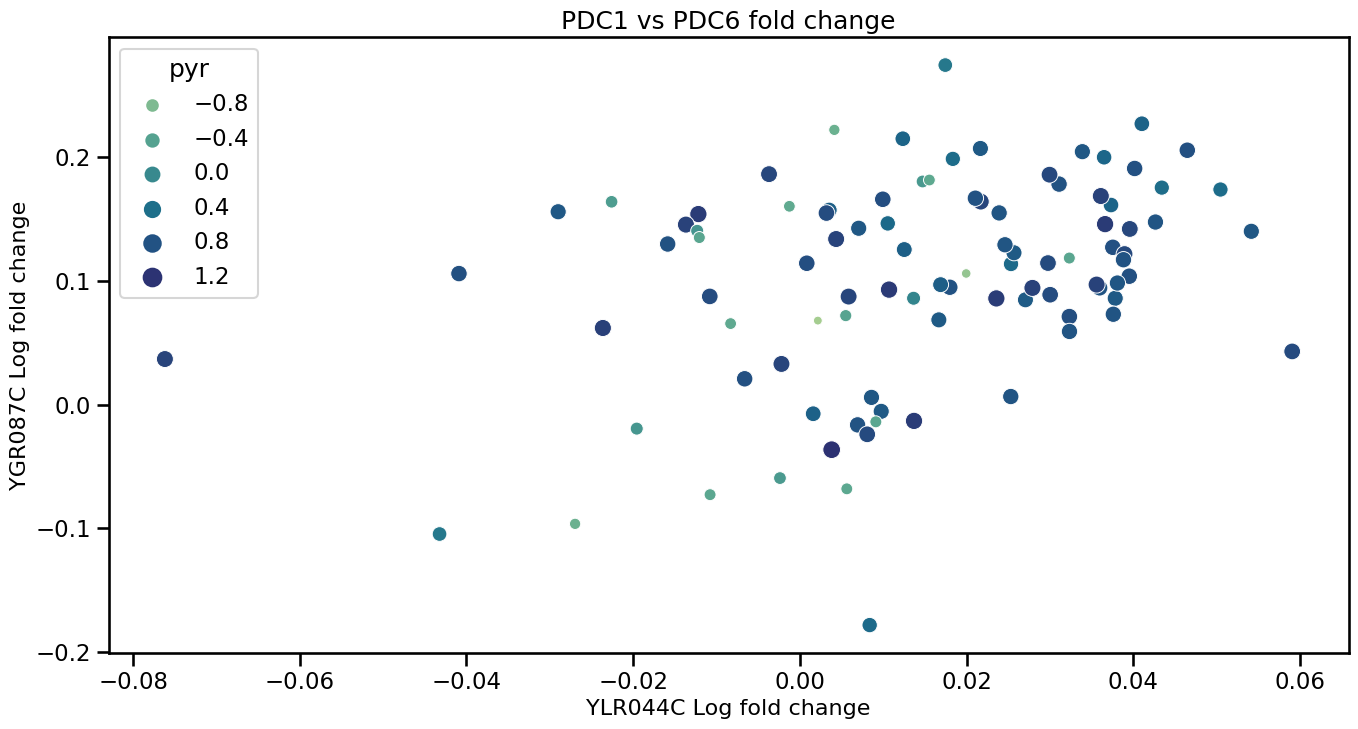

In [62]:
fig, (ax1) = plt.subplots(1, 1, figsize=(16, 8))
_df = pd.concat([
    tf.x.droplevel(1).drop_duplicates(), 
    tf.y.unstack(1)
], axis=1)

sns.scatterplot(
    data=_df,
    x="YLR044C",
    y="YGR087C",
    hue='pyr',
    size='pyr',
    palette='crest',
    ax=ax1,
).set(
    title='PDC1 vs PDC6 fold change',
    xlabel='YLR044C Log fold change',
    ylabel='YGR087C Log fold change'
)
plt.show()

# Load optimal model

In [63]:
with open(f'./model/Tier.TIER0/Strategy.ALL_all.pickle', 'rb') as handle:
    model = pickle.load(handle)

with open(f'./model/Tier.TIER0/Strategy.METABOLITE_CENTRIC_pyr.pickle', 'rb') as handle:
    model_tier_0_metabolite_strategy = pickle.load(handle)

with open(f'./model/Tier.TIER0/Strategy.ONE_VS_ALL_pyr.pickle', 'rb') as handle:
    model_tier_0_one_vs_all = pickle.load(handle)

predictions = model.predict(tf.x.xs(key='pyr', axis=0, level=1))
predictions_metabolite = model_tier_0_metabolite_strategy.predict(tf.x.xs(key='pyr', axis=0, level=1))
predictions_one_vs_all = model_tier_0_one_vs_all.predict(tf.x.xs(key='pyr', axis=0, level=1))

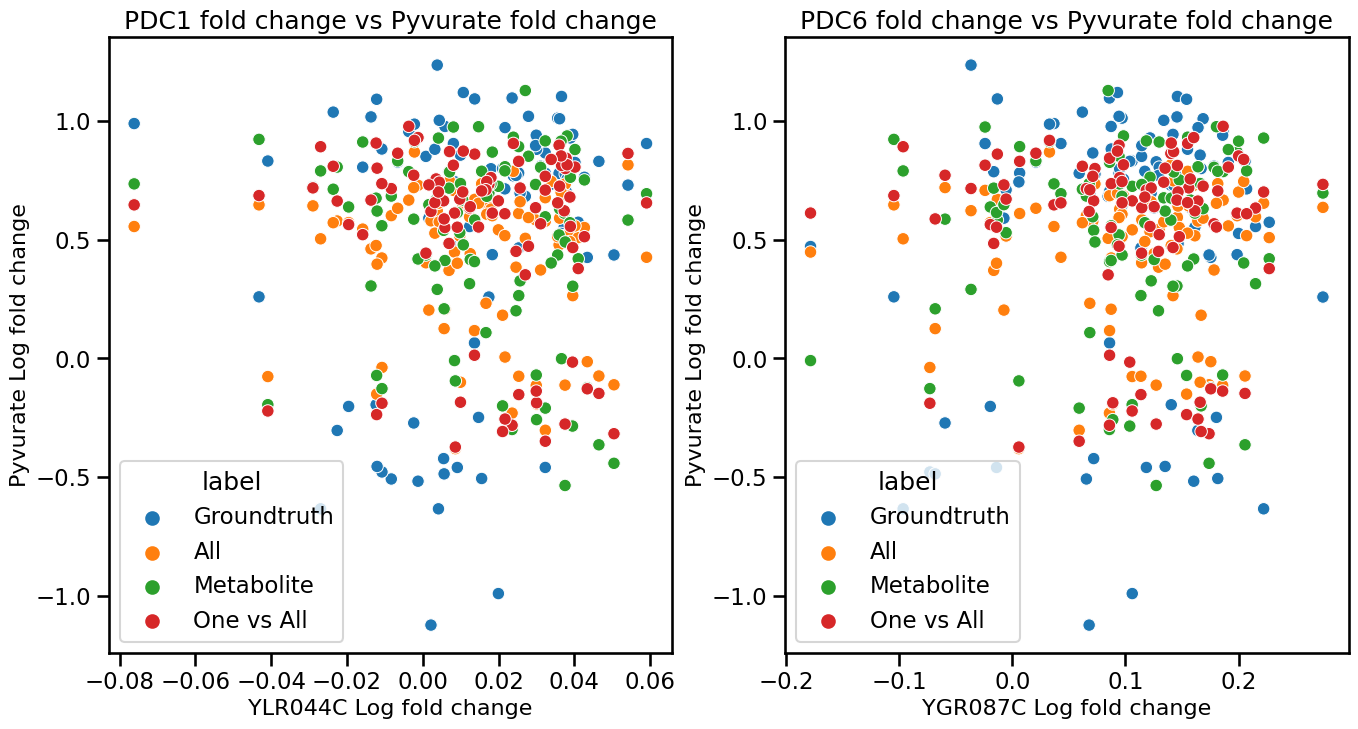

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
_df = pd.concat([
    tf.x.droplevel(1).drop_duplicates(), 
    tf.y.unstack(1)
], axis=1)

_df = _df.assign(predictions=predictions)
_df = _df.assign(predictions_metabolite=predictions_metabolite)
_df = _df.assign(predictions_one_vs_all=predictions_one_vs_all)
_df = _df[['YLR044C', 'YGR087C', 'pyr', 'predictions', 'predictions_metabolite', 'predictions_one_vs_all']].reset_index()

_df = pd.concat([
    _df[['YLR044C', 'YGR087C', 'pyr']].rename({'pyr': 'fc'}, axis=1).assign(label='Groundtruth'),
    _df[['YLR044C', 'YGR087C', 'predictions']].rename({'predictions': 'fc'}, axis=1).assign(label='All'),
    _df[['YLR044C', 'YGR087C', 'predictions_metabolite']].rename({'predictions_metabolite': 'fc'}, axis=1).assign(label='Metabolite'),
    _df[['YLR044C', 'YGR087C', 'predictions_one_vs_all']].rename({'predictions_one_vs_all': 'fc'}, axis=1).assign(label='One vs All'),
], axis=0, ignore_index=True)

sns.scatterplot(
    data=_df,
    x="YLR044C",
    y="fc",
    hue='label',
    ax=ax1
).set(
    title='PDC1 fold change vs Pyvurate fold change',
    xlabel='YLR044C Log fold change',
    ylabel='Pyvurate Log fold change'
)
sns.scatterplot(
    data=_df,
    x="YGR087C",
    y="fc",
    hue='label',
    ax=ax2,
).set(
    title="PDC6 fold change vs Pyvurate fold change",
    xlabel='YGR087C Log fold change',
    ylabel='Pyvurate Log fold change'
)
plt.show()